# Comparing Elementary Conversion Modes with Minimal Pathways

I have enumerated Elementary Conversion Modes (ECMs) and Minimal Pathways (MPs) on models e_coli_core, iIT341 and iJR904. In this notebook I compare the results I got from each enumeration and compare the different pathway analysis methods.

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from functions import*
import scipy.spatial.distance
import cobra
#import fastcluster

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Heatmaps

In [2]:
# Make heatmap dataframes
iIT = cobra.io.read_sbml_model('../models/iIT341_ecm_minII.xml')
ec_core = cobra.io.read_sbml_model('../models/e_coli_core.xml')

ecm_e_coli_core = prepare_ecm_heatmap(ecm_file='../results/ecm/e_coli_core.csv', name_file='output/metabolite_names_e_coli_core.txt')
mp_e_coli_core = prepare_mp_heatmap(mp_file='../results/mp/e_coli_core_20230119_13242764666_complete_mps.csv', model=ec_core)
ecm_iIT341 = prepare_ecm_heatmap('../results/ecm/iIT_minII.csv', name_file='output/metabolite_names_iIT341.txt')
mp_iIT341 = prepare_mp_heatmap('../results/mp/iIT341_20221126_0145381771426_complete_mps.csv', model=iIT)

# Global settings
sns.set(font_scale=1.25)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-06


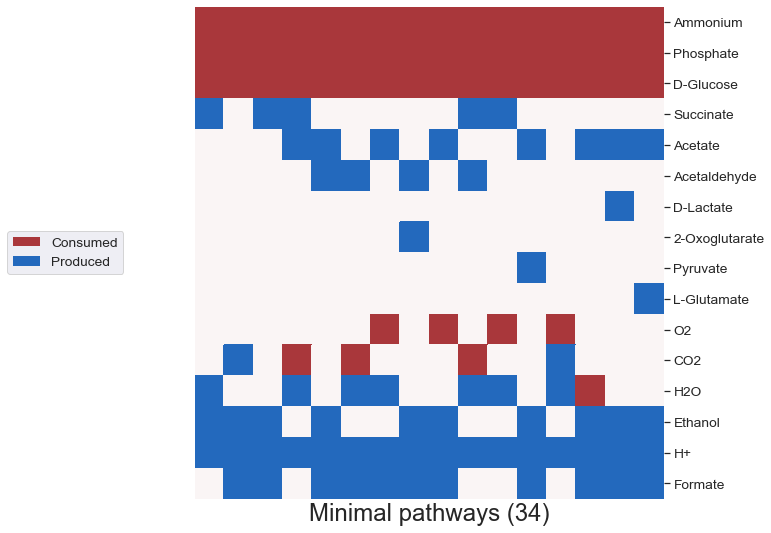

In [3]:
# Compute linkage seperately such that it can be used in another plot
clust = scipy.cluster.hierarchy.linkage(mp_e_coli_core.to_numpy(), method='ward', metric='euclidean')

# Color legend
coloring = sns.color_palette('vlag_r', as_cmap=True)
direction_lut = {'Consumed':coloring.colors[0], 'Produced':coloring.colors[-1]}

# Render figure
g = sns.clustermap(mp_e_coli_core, row_linkage=clust, col_linkage=clust, cmap='vlag_r', xticklabels=0, yticklabels=1, figsize=(10,9), tree_kws={'colors':(1,1,1)})
g.ax_cbar.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
g.ax_heatmap.set_xlabel(f'Minimal pathways ({mp_e_coli_core.shape[1]})', size=24)

for label, color in direction_lut.items():
   g.ax_row_dendrogram.bar(0, 0, color=color, label=label, linewidth=0)
l1 = g.ax_row_dendrogram.legend(title='', loc="center", bbox_to_anchor=(-0.1, 0.5))

plt.savefig('figures/mps_ecolic.svg', bbox_inches='tight', dpi=300, format='svg')

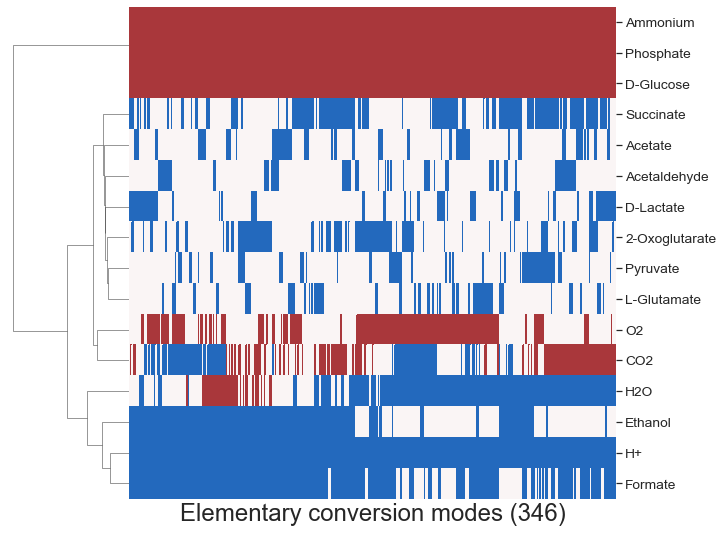

In [4]:
# Reorder ECM df
ecm_e_coli_core = ecm_e_coli_core.reindex(mp_e_coli_core.index, axis=1)

# Render figure
cmap = sns.clustermap(ecm_e_coli_core.T, row_linkage=clust, cmap='vlag_r',xticklabels=0, figsize=(10.3,9))
cmap.ax_cbar.set_visible(False)
cmap.ax_col_dendrogram.set_visible(False)
cmap.ax_heatmap.set_xlabel(xlabel= f'Elementary conversion modes ({ecm_e_coli_core.shape[0]})', size=24)

plt.savefig('figures/ecms_ecolic', bbox_inches='tight', dpi=300)

In [5]:
# Make clusterobject to use on other heatmaps
clust = scipy.cluster.hierarchy.linkage(mp_iIT341.to_numpy(), method='ward', metric='euclidean')

# Render figure
g = sns.clustermap(mp_iIT341, method='ward', row_linkage=clust, cmap='vlag_r', xticklabels=0, yticklabels=1, figsize=(10,11))
g.ax_col_dendrogram.set_visible(False)
g.ax_row_dendrogram.set_visible(False)
g.ax_cbar.set_visible(False)
g.ax_heatmap.set_xlabel(xlabel= f'Minimal pathways ({mp_iIT341.shape[1]})', size=24)

plt.savefig('figures/mps_HP', bbox_inches='tight', dpi=300)

I am able to cluster all rows of ecms by using fastcluster. My PC did not allow me to allocate enough memory for the `fastcluster.linkage` method, so I resorted to the `fastcluster.linkage_vector` method. The vector method uses memory saving algorithms, reducing the memory from $\Theta(N^2)$ to $\Theta(N \times D)$ of $N$ observations in $\mathbb{R}^D$ dimensions (ref. [fastcluster manual](https://pypi.org/project/fastcluster/)). It still took about 20 minutes to completely cluster all ECMs. Therefore I wrote the results to a file that can be read by the `np.loadtxt` method. The commented code chunk below can be used to replicate the fastcluster results, but is commented out to save time.

In [6]:
# Fastcluster ECM results
# import fastcluster
# import scipy.spatial.distance

# fast_clust = fastcluster.linkage_vector(ecm_df.to_numpy(), method='ward', metric='euclidean') # Time: 19 m 39.4 s

# np.savetxt('results/ecm/fastcluster_iIT341_ecms.gz', fast_clust)

In [7]:
fast_clust_cp = np.loadtxt('output/fastcluster_iIT341_ecms.gz')

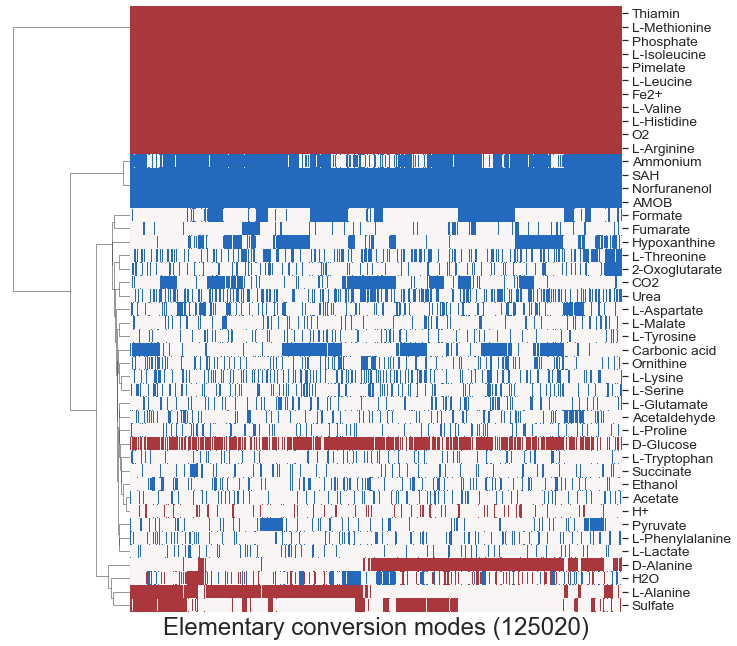

In [8]:
# Reorder ecm df
ecm_iIT341 = ecm_iIT341.reindex(mp_iIT341.index, axis=1)

# Render figure
clmap = sns.clustermap(ecm_iIT341.T, cmap='vlag_r', col_linkage=fast_clust_cp, row_linkage=clust, xticklabels=0, yticklabels=1, cbar=False, figsize=(10.5,11))
clmap.ax_cbar.set_visible(False)
clmap.ax_col_dendrogram.set_visible(False)
clmap.ax_heatmap.set_xlabel(xlabel= f'Elementary conversion modes ({ecm_iIT341.shape[0]})', size=24)
clmap.savefig('figures/ecms_HP', bbox_inches='tight', dpi=300)

# Comparison of metabolite sets

In [9]:
# Create metabolite sets of mps and ecms
ecms_ecoli_core = create_ecm_metabolite_sets(ecm_e_coli_core)
mps_e_coli_core = list_mp_results(mp_file='../results/mp/e_coli_core_20230119_13242764666_complete_mps.csv', model=ec_core)

ecms_iIT341 = create_ecm_metabolite_sets(ecm_iIT341)
mps_iIT341 = list_mp_results(mp_file='../results/mp/iIT341_20221126_0145381771426_complete_mps.csv', model=iIT)

In [10]:
# Inspection of MPs that are subset of ECMs
# Which metabolites are not present in the MPs that are subsets of a given ECM?
for ecm in ecms_ecoli_core:
    print()
    print(ecm)
    for mp in mps_e_coli_core:
        if mp<=ecm:
            print(mp - ecm)

# For ECM 1, how do the MPs differ from the ECMs and vice versa?
print('--------')
print(f'ECM1: {ecms_ecoli_core[1]}') 
for mp in mps_e_coli_core:   
    print('--------')
    print(mp - ecms_ecoli_core[1])
    print(ecms_ecoli_core[1] - mp)


{'CO2_rev', 'H2O', 'Formate', 'Phosphate_rev', 'D-Glucose_rev', 'Ammonium_rev', 'D-Lactate', '2-Oxoglutarate', 'H+'}
set()

{'Formate', 'Phosphate_rev', 'D-Glucose_rev', 'Acetaldehyde', 'Ethanol', 'Ammonium_rev', 'O2_rev', '2-Oxoglutarate', 'H+'}
set()
set()

{'H2O', 'Formate', 'Phosphate_rev', 'D-Glucose_rev', 'Ammonium_rev', 'O2_rev', '2-Oxoglutarate', 'H+'}
set()

{'Succinate', 'Formate', 'Acetate', 'Phosphate_rev', 'D-Glucose_rev', 'H2O_rev', 'Ethanol', 'Ammonium_rev', 'H+'}
set()
set()

{'H2O', 'Formate', 'Phosphate_rev', 'D-Glucose_rev', 'Ammonium_rev', 'O2_rev', 'D-Lactate', 'H+'}
set()

{'Formate', 'Acetate', 'Phosphate_rev', 'D-Glucose_rev', 'Ethanol', 'Ammonium_rev', 'O2_rev', 'H+'}
set()

{'Succinate', 'CO2_rev', 'H2O', 'Phosphate_rev', 'D-Glucose_rev', 'Ammonium_rev', 'D-Lactate', 'H+'}
set()

{'Formate', 'Phosphate_rev', 'D-Glucose_rev', 'Ethanol', 'Ammonium_rev', 'O2_rev', 'Pyruvate', 'H+', 'CO2'}
set()

{'Succinate', 'H2O', 'Formate', 'Phosphate_rev', 'D-Glucose_rev', '

The first output shows how many subsets of metabolites in each ECM that are exactly an MP. Each ECM set of metabolites has at least one MP subset of metabolites. 

The second output shows the difference in terms of which metabolites are included in the ECM with index 1 compared to each MP subset of metabolites. The set of MP metabolites are always smaller than the set of metabolites of ECM with index 1. D-Lactate and consumption of CO2 are present in ECM with index 1, but absent in most MPs.

In [11]:
# Visualize ECM and MP comparison. How many subsets can we find for each MP?

# Calculate Jaccard distance between all MPs and ECMs
# dist = np.zeros((len(mps_e_coli_core), len(ecms_ecoli_core)))
# for i, mp in enumerate(mps_e_coli_core):
#     for j, ecm in enumerate(ecms_ecoli_core):
#         if mp<=ecm:
#             dist[i,j] = len(mp & ecm)/len(mp | ecm)
#         else:
#             dist[i,j] = 0

In [12]:
# Clustered heatmap of similarity
#sns.clustermap(dist, col_cluster=True, cmap='RdBu', xticklabels=0, yticklabels=0, center=0, method = 'ward', figsize=(20, 10))
#plt.savefig('results/figures/heatmaps/cluster_ecoli')

In [13]:
# In this case, the union of metabolites in all ECMs are the same as the union of metabolites in all MPs.
print(set.union(*ecms_ecoli_core)-set.union(*mps_e_coli_core), set.union(*mps_e_coli_core)-set.union(*ecms_ecoli_core))

set() set()


In [14]:
# Count how many ecm metabolite subsets exist for each mp and how many mp metabolite subsets exist for each ecm
(sets_in_mps, sets_in_ecms, no_sets_in_mps, no_sets_in_ecms) = count_metabolite_sets(mps_e_coli_core, ecms_ecoli_core, return_zeros=True)
print(no_sets_in_mps, no_sets_in_ecms)

[] []


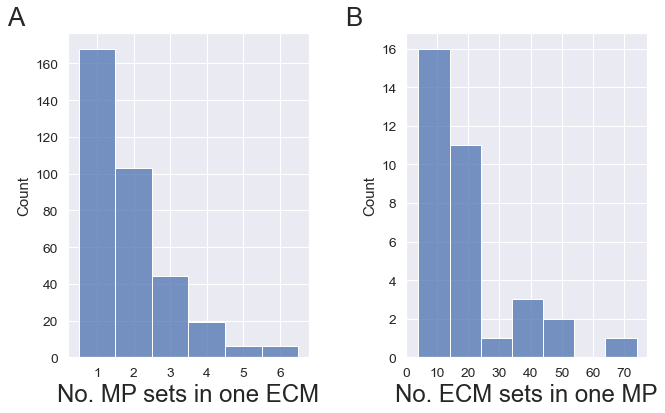

In [15]:
# Plot histograms
f = plt.figure()

# Define these variables to align the x ticks correctly
xmin_ecm, xmax_ecm = np.min(sets_in_ecms), np.max(sets_in_ecms)
bins = xmax_ecm - xmin_ecm + 1
binrange = xmin_ecm - 0.5, xmax_ecm + 0.5

plt.subplot(1,3,1)
ax = sns.histplot(sets_in_ecms, stat='count', bins=bins, binrange=binrange)
ax.text(-0.25, 1.025, 'A', transform=ax.transAxes, size=26)
plt.xlabel('No. MP sets in one ECM', fontsize=24)
plt.xticks(range(xmin_ecm, xmax_ecm + 1))

plt.subplot(1,3,2)
ax = sns.histplot(sets_in_mps, binwidth=10, stat='count')
ax.text(-0.25, 1.025, 'B', transform=ax.transAxes, size=26)
plt.xlabel('No. ECM sets in one MP', fontsize=24)
plt.xticks(range(0, 80, 10))

f.set_size_inches(14, 6)
plt.tight_layout()
plt.subplots_adjust(wspace=0.4)
f.savefig('figures/hist_e_coli_core')

Can all MPs be found in the set of ECMs?

In [16]:
# By tweaking the boundaries of the model we were able to find a matching ECM for all MPs
for mp in mps_e_coli_core:
    if mp not in ecms_ecoli_core:
        print('not all MPs can be found in ECMs')
        break

We found out that all MPs are ECMs! This has multiple implications:

* The flux space of MPs are indeed a subspace of the conversion cone of ECMs.
* By definition, MPs are support minimal for a given metabolic functionality (in our case, growth). Because the MPs are ECMs as well, they must be the set of ECMs that are support minimal under equivalent constraints as MP solution space (i.e. growth requirement and equivalent homogeneous flux constraints).

Though these implications are not yet proven, I should be able to find the set of support minimal ECMs and find that they are equal to the MPs, if these implications are true. In the [mptool paper](https://www.biorxiv.org/content/10.1101/2020.07.31.230177v2), a pathway is support minimal if it only contains exchange reactions that doesn't allow growth when any reaction in the pathway is knocked out. Thus, I can try checking if the organism is able to grow for each pathway after knocking out each exchange reaction one by one in each pathway. If it is not able to grow at all, the pathway is support minimal.

In [17]:
namedict = generate_mp_namedict(ec_core)
iddict = {val:key for key,val in namedict.items()}

supp_min = find_support_minimal_set(ec_core, ecms_ecoli_core, iddict, tol=1e-4)

In [18]:
print(len(supp_min))
for ecm in supp_min:
    if ecm not in mps_e_coli_core:
        print(f'Not all support minimal ECMs can be found in MPs: {ecm}')
        break

34


Looks like all support minimal ECMs are exactly the set of MPs! 

We may not be able to visualize full heatmap where all ECMs and MPs are visible like for `e_coli_core`. To summarize the connection between MPs and ECMs, for each ECM, we count how many MPs that are a subset for each ECM. Equivalently, for each MP, we count how many MPs that are a subset of ECMs.

In [21]:
# Number of MPs that are a subset for each ECM and number of ECMs that are a superset of each MP
(sets_in_mps, sets_in_ecms) = count_metabolite_sets(mps_e_coli_core, ecms_ecoli_core) 

In [22]:
# How many ECMs did not have a subset of metabolites that corresponded to an MP and vice versa?
for counts in (sets_in_ecms, sets_in_mps):
    zeros = [x for x in counts if x == 0]
    print(len(zeros))

0
0


Some ECMs produced very little biomass. Therefore not all ECMs were represented in the MPs. There are only 30 ECMs that do not have any MP subset! All ECMs are fully represented by the MP subsets.

In [23]:
# Minimum and maximum count of sets for ecms and mps
print(min(sets_in_ecms), max(sets_in_ecms))
print(min(sets_in_mps), max(sets_in_mps))

1 6
4 73


There are up to 11 MPs that are subsets of the same ECM, while there are at least one up to 4343 ECMs that share MP subset.

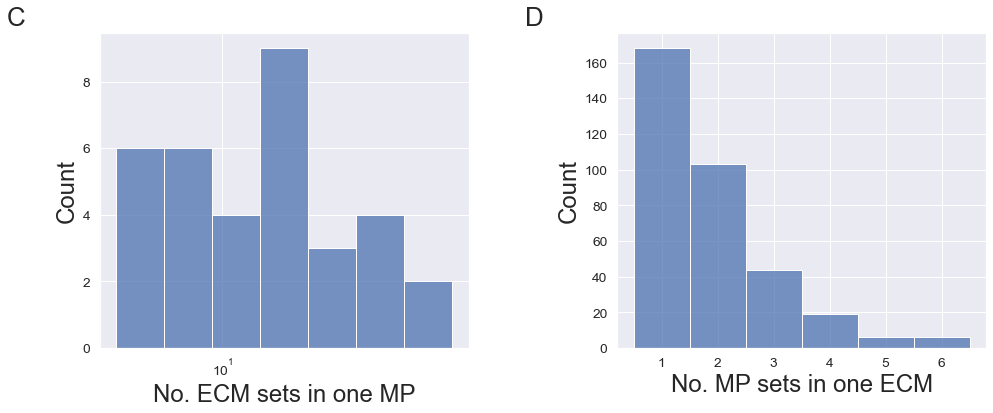

In [25]:
# Plot histograms
f = plt.figure()
#f.suptitle('Counts of subsets of metabolites for iIT341', fontsize=18)

xmin_ecm, xmax_ecm = np.min(sets_in_ecms), np.max(sets_in_ecms)
bins = xmax_ecm - xmin_ecm + 1
binrange = xmin_ecm - 0.5, xmax_ecm + 0.5

plt.subplot(1,2,1)
ax = sns.histplot(sets_in_mps, stat='count', log_scale=True)
ax.text(-0.25, 1.025, 'C', transform=ax.transAxes, size=26)
plt.xlabel('No. ECM sets in one MP', fontsize=24)
plt.ylabel('Count', fontsize=24)

plt.subplot(1,2,2)
ax = sns.histplot(sets_in_ecms, stat='count', binrange=binrange, bins=bins)
ax.text(-0.25, 1.025, 'D', transform=ax.transAxes, size=26) 
plt.xlabel('No. MP sets in one ECM', fontsize=24)
plt.ylabel('Count', fontsize=24)
plt.xticks(range(xmin_ecm, xmax_ecm + 1))

f.set_size_inches(14, 6)
plt.tight_layout()
plt.subplots_adjust(wspace=0.4)
f.savefig('figures/hist_e_coli_core.png')

In [27]:
print(set.union(*mps_e_coli_core) - set.union(*ecms_ecoli_core))
print(set.union(*ecms_ecoli_core) - set.union(*mps_e_coli_core))

set()
set()


Let's check if it is possible to retrieve all support minimal pathways from ECMs for iIT341 as well. It could take extremely long time unless I improve the performance of the code... A day is a comfortable estimate, but I'm not sure. I might try to run this in Orion instead.

In [28]:
# %%capture
# model = cobra.io.read_sbml_model('models/iIT341_ecm_minII.xml')
# namedict = read_dict_from_file('results/mp/iIT341_metabnames_mp.csv')
# iddict = {val:key for key,val in namedict.items()}

# supp_min = find_support_minimal_set(model, ecms, iddict, tol=1e-4)

# iIT341 hide

Do not need to include this example, though is the only example where the ECMs group into the MPs nicely.

### Visualize ECMs

In [30]:
ecm_df = prepare_ecm_heatmap('../results/ecm/iIT_hide.csv', name_file='output/metabolite_names_iIT341.txt')
ecm_df.shape

(32, 17)

In [31]:
# For reproduction of heatmap presented in ecmtool paper
#dropcols = ['Thiamin', 'L-Methionine', 'L-Leucine', 'L-Isoleucine', 'L-Histidine', 'Fe2+ mitochondria', 'L-Valine', 
#           'Pimelate', 'Phosphate']
#unique_df = unique_df.drop(columns=dropcols)
#unique_df.shape

In [32]:
# Render figure
cmap = sns.clustermap(ecm_df.T, cmap='RdBu', center=0, xticklabels=0)
cmap.ax_row_dendrogram.set_visible(False)
cmap.ax_col_dendrogram.set_visible(False)
cmap.fig.subplots_adjust(right=0.9)
cmap.ax_cbar.set_position((0.1, .2, .03, .4))
#plt.savefig('results/figures/heatmaps/ecms_hideoutputs', bbox_inches='tight')

### Visualize MPs

In [35]:
mp_df = prepare_mp_heatmap('../results/mp/iIT341_inputs_20221121_1447199555998_complete_mps.csv', model=iIT)

FileNotFoundError: [Errno 2] No such file or directory: '../results/mp/iIT341_inputs_20221121_1447199555998_complete_mps.csv'

In [81]:
# Render figure
g = sns.clustermap(mp_df, cmap='RdBu', center=0, xticklabels=0)
g.ax_row_dendrogram.set_visible(False)
g.ax_col_dendrogram.set_visible(False)
g.fig.subplots_adjust(right=0.9)
g.ax_cbar.set_position((0.1, .2, .03, .4))
#plt.savefig('results/figures/heatmaps/mps_hideoutputs', bbox_inches='tight')

### ECM and MP comparison for iIT341 hide outputs

#### Make each ECM a set of metabolites

In [36]:
# Make list of metabolite sets for each mp and ecm
ecms = create_ecm_metabolite_sets(ecm_df)
mps = list_mp_results(mp_file='results\mp\iIT341_inputs_20221121_1447199555998_complete_mps.csv', model=iIT)

TypeError: list_mp_results() got an unexpected keyword argument 'rename_file'

In [83]:
# Calculate Jaccard distance between all MPs and ECMs
dist = np.zeros((len(mps), len(ecms)))
for i, mp in enumerate(mps):
    for j, ecm in enumerate(ecms):
        if mp<=ecm:
            dist[i,j] = len(mp & ecm)/len(mp | ecm)
        else:
            dist[i,j] = 0

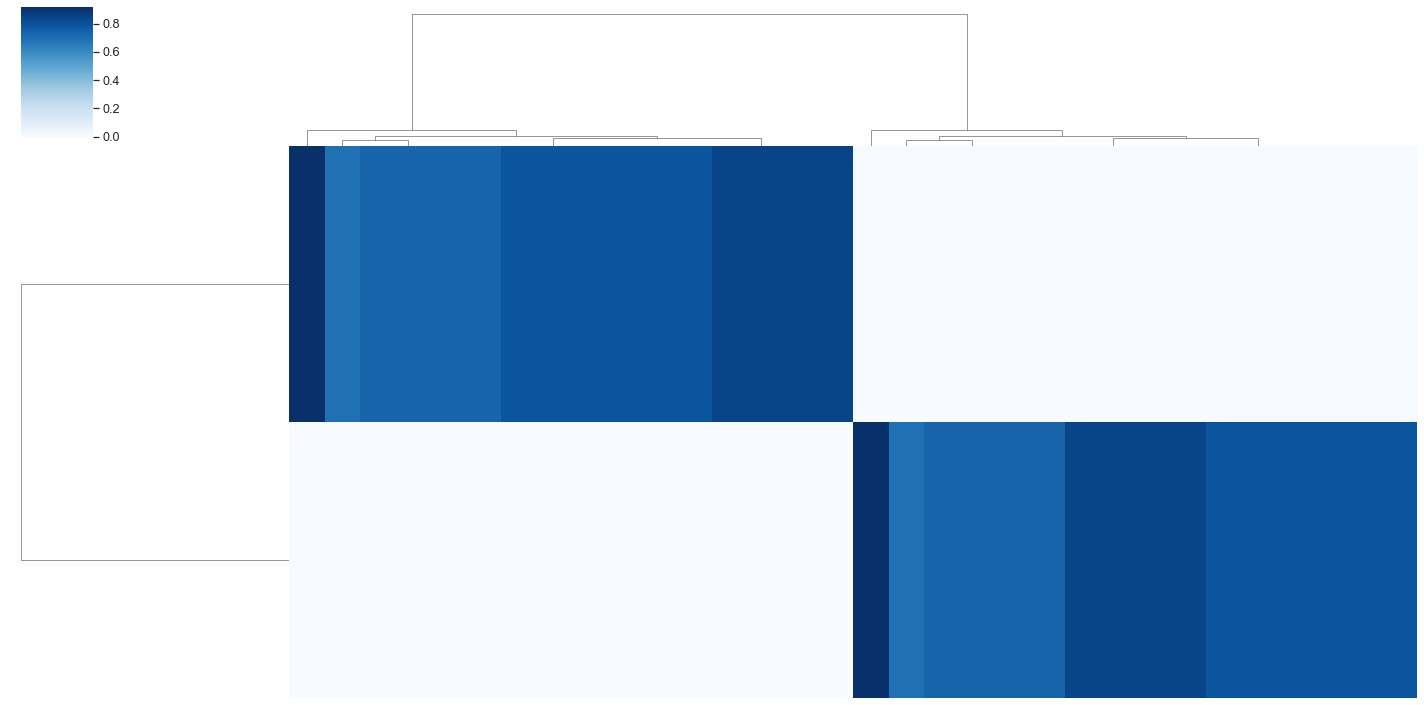

In [84]:
# Clustered heatmap of similarity
g = sns.clustermap(dist, col_cluster=True, cmap='Blues', xticklabels=0, yticklabels=0, figsize=(20, 10))
#plt.savefig('results/figures/heatmaps/cluster_hideoutputs')